### Notebook for plotting the figures for the Adaptation section

In [385]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import yaml
from pathlib import Path
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, ListedColormap, BoundaryNorm
from matplotlib.colorbar import ColorbarBase
import matplotlib.patches as mpatches
import matplotlib as mpl
from adjustText import adjust_text

#### Define Functions

In [386]:
# Define function combining country inequality metric geopackages
def combine_national_bcr_metrics(country_list, model, ADM_level, fp_urban, fp_rp, rl_urban):
    '''
    Function for combining country's BCR metrics. This function takes as input
        - the list of countries to combine (ISO3 codes)
        - the flood model used (giri, jrc, or wri)
        - the administrative level to focus on (ADM0, ADM1, ADM2)
        - the GHS urbanization threshold for flood protection (21, 22, 23, etc.)
        - the design level of flood protection (50, 100)
        - the GHS urbanization threshold for relocation (11, 12, 23, etc.)
    The outputs of this function are:
        - a combined geodataframe of baseline risk metrics
        - a combined geodataframe of adapted (flood protection) risk metrics
        - a combined geodataframe of adapted (dry proofing) risk metrics
        - a combined geodataframe of adapted (relocation) risk metrics
        - a combined goedataframe of adaptation costs (flood protection)
        - a combined goedataframe of adaptation costs (dry proofing)
        - a combined geodataframe of adaptation costs (relocation)
    '''
    # Lists to store individual GeoDataFrames
    baseline_gdfs = []
    adapted_fp_gdfs = []
    adapted_dp_gdfs = []
    adapted_rl_gdfs = []
    cost_fp_gdfs = []
    cost_dp_gdfs = []
    cost_rl_gdfs = []
    # Loop over all countries in the country list
    for country in country_list:
        try:
            baseline_path = os.path.join("..", "data", "results", "flood_risk", "summary", "countries", 
                                                country, f"{country}_{ADM_level}_metrics_{model}-flood_AALs_baseline_capstock.gpkg")
            adapted_fp_path = os.path.join("..", "data", "results", "flood_risk", "summary", "countries",
                                          country, f"{country}_{ADM_level}_metrics_{model}-flood_AALs_adapted_fp_rp{fp_rp}_duc{fp_urban}_capstock.gpkg")
            adapted_dp_path = os.path.join("..", "data", "results", "flood_risk", "summary", "countries",
                                          country, f"{country}_{ADM_level}_metrics_{model}-flood_AALs_adapted_dp_capstock.gpkg")
            adapted_rl_path = os.path.join("..", "data", "results", "flood_risk", "summary", "countries",
                                          country, f"{country}_{ADM_level}_metrics_{model}-flood_AALs_adapted_rl_duc{rl_urban}_capstock.gpkg")
            cost_fp_path = os.path.join("..", "data", "results", "adaptation", "costs", "countries",
                                       country, f"{country}_adaptation-cost_fp_rp{fp_rp}_duc{fp_urban}_{ADM_level}.gpkg")
            cost_dp_path = os.path.join("..", "data", "results", "adaptation", "costs", "countries",
                                       country, f"{country}_adaptation-cost_dp_m-{model}_{ADM_level}.gpkg")
            cost_rl_path = os.path.join("..", "data", "results", "adaptation", "costs", "countries",
                                       country, f"{country}_adaptation-cost_rl_m-{model}_duc{rl_urban}_{ADM_level}.gpkg")
            # Read the GeoPackages
            gdf_baseline = gpd.read_file(baseline_path)
            gdf_adapted_fp = gpd.read_file(adapted_fp_path)
            gdf_adapted_dp = gpd.read_file(adapted_dp_path)
            gdf_adapted_rl = gpd.read_file(adapted_rl_path)
            gdf_cost_fp = gpd.read_file(cost_fp_path)
            gdf_cost_dp = gpd.read_file(cost_dp_path)
            gdf_cost_rl = gpd.read_file(cost_rl_path)
            # Append to list
            baseline_gdfs.append(gdf_baseline)
            adapted_fp_gdfs.append(gdf_adapted_fp)
            adapted_dp_gdfs.append(gdf_adapted_dp)
            adapted_rl_gdfs.append(gdf_adapted_rl)
            cost_fp_gdfs.append(gdf_cost_fp)
            cost_dp_gdfs.append(gdf_cost_dp)
            cost_rl_gdfs.append(gdf_cost_rl)
        except Exception as e:
            print(f"Error processing {country}: {e}")

    # Combine all GeoDataFrames
    combined_baseline_gdf = pd.concat(baseline_gdfs, ignore_index=True)
    combined_adapted_fp_gdf = pd.concat(adapted_fp_gdfs, ignore_index=True)
    combined_adapted_dp_gdf = pd.concat(adapted_dp_gdfs, ignore_index=True)
    combined_adapted_rl_gdf = pd.concat(adapted_rl_gdfs, ignore_index=True)
    combined_cost_fp_gdf = pd.concat(cost_fp_gdfs, ignore_index=True)
    combined_cost_dp_gdf = pd.concat(cost_dp_gdfs, ignore_index=True)
    combined_cost_rl_gdf = pd.concat(cost_rl_gdfs, ignore_index=True)
    
    return combined_baseline_gdf, combined_adapted_fp_gdf, combined_adapted_dp_gdf, combined_adapted_rl_gdf, combined_cost_fp_gdf, combined_cost_dp_gdf, combined_cost_rl_gdf

def combine_national_CI_metrics(country_list, model, fp_urban, fp_rp, rl_urban):
    '''
    Function for combining country's CI metrics at ADM0. This function takes as input
        - the list of countries to combine (ISO3 codes)
        - the flood model used (giri, jrc, or wri)
        - the GHS urbanization threshold for flood protection (21, 22, 23, etc.)
        - the design level of flood protection (50, 100)
        - the GHS urbanization threshold for relocation (11, 12, 23, etc.)
    The outputs of this function are:
        - a combined geodataframe of baseline CI metrics
        - a combined geodataframe of adapted (flood protection) CI metrics
        - a combined geodataframe of adapted (dry proofing) CI metrics
        - a combined geodataframe of adapted (relocation) CI metrics
    '''
    # Lists to store individual GeoDataFrames
    baseline_gdfs = []
    adapted_fp_gdfs = []
    adapted_dp_gdfs = []
    adapted_rl_gdfs = []
    # Loop over all countries in the country list
    for country in country_list:
        try:
            baseline_path = os.path.join("..", "data", "results", "social_flood", "countries", country, "inequality_metrics", 
                                            f"{country}_ADM0_metrics_{model}-flood_protected_AAR_V-JRC_S-rwi.gpkg")
            adapted_fp_path = os.path.join("..", "data", "results", "social_flood", "countries", country, "inequality_metrics", 
                                            f"{country}_ADM0_metrics_{model}-flood_adapted_AAR_V-JRC_S-rwi_fp_rp{fp_rp}_duc{fp_urban}.gpkg")
            adapted_dp_path = os.path.join("..", "data", "results", "social_flood", "countries", country, "inequality_metrics", 
                                            f"{country}_ADM0_metrics_{model}-flood_adapted_AAR_V-JRC_S-rwi_dp.gpkg")
            adapted_rl_path = os.path.join("..", "data", "results", "social_flood", "countries", country, "inequality_metrics", 
                                            f"{country}_ADM0_metrics_{model}-flood_adapted_AAR_V-JRC_S-rwi_rl_duc{rl_urban}.gpkg")
            # Read the GeoPackages
            gdf_baseline = gpd.read_file(baseline_path)
            gdf_adapted_fp = gpd.read_file(adapted_fp_path)
            gdf_adapted_dp = gpd.read_file(adapted_dp_path)
            gdf_adapted_rl = gpd.read_file(adapted_rl_path)
            # Append to list
            baseline_gdfs.append(gdf_baseline)
            adapted_fp_gdfs.append(gdf_adapted_fp)
            adapted_dp_gdfs.append(gdf_adapted_dp)
            adapted_rl_gdfs.append(gdf_adapted_rl)
        except Exception as e:
            print(f"Error processing {country}: {e}")

    # Combine all GeoDataFrames
    combined_baseline_gdf = pd.concat(baseline_gdfs, ignore_index=True)
    combined_adapted_fp_gdf = pd.concat(adapted_fp_gdfs, ignore_index=True)
    combined_adapted_dp_gdf = pd.concat(adapted_dp_gdfs, ignore_index=True)
    combined_adapted_rl_gdf = pd.concat(adapted_rl_gdfs, ignore_index=True)

    return combined_baseline_gdf, combined_adapted_fp_gdf, combined_adapted_dp_gdf, combined_adapted_rl_gdf

# Define BCR function
def calculate_bcr(baseline_df, adapted_df, cost_df, time_period, discount_rate):
    # merge all dataframes on shapename
    merged_df = baseline_df[['shapeName', 'total_losses']].merge(
        adapted_df[['shapeName', 'total_losses']],
        on='shapeName',
        suffixes=('_baseline', '_adapted')
    ).merge(
        cost_df[['shapeName', 'adaptation_cost']],
        on='shapeName'
    )
    # Calculate actual benefits
    merged_df['annual_benefits'] = (
        merged_df['total_losses_baseline'] -
        merged_df['total_losses_adapted']
    )
    # Calculate present value of benefits over time period
    if discount_rate ==0:
        pv_factor = time_period
    else:
        pv_factor = (1-(1 + discount_rate)** -time_period) / discount_rate
    merged_df['pv_benefits'] = merged_df['annual_benefits'] * pv_factor
    # Calculate benefit-cost ratio
    merged_df['bcr'] = merged_df['pv_benefits'] / merged_df['adaptation_cost']
    # Handle division by 0 or negative costs
    merged_df['bcr'] = merged_df['bcr'].replace([np.inf, -np.inf], np.nan)
    # Create results dataframe
    results_df = merged_df[[
        'shapeName',
        'annual_benefits',
        'pv_benefits',
        'adaptation_cost',
        'bcr'
    ]]
    # Pull geometry
    results_gdf = baseline_df[['shapeName', 'geometry']].merge(
        results_df,
        on='shapeName',
        how='right'
    )

    return results_gdf

# Define CI improvement function
def calculate_ci_change(baseline_df, adapted_df):
    # What columns are we interested in?
    columns_to_keep = ['CI', 'Q1 Flood Risk', 'Q2 Flood Risk', 'Q3 Flood Risk', 'Q4 Flood Risk', 'Q5 Flood Risk']
    # merge all dataframes on shapename
    merged_df = baseline_df[['shapeName'] + columns_to_keep].merge(
        adapted_df[['shapeName']+columns_to_keep],
        on='shapeName',
        suffixes=('_baseline', '_adapted')
    )
    # Calculate CI improvement benefits
    for i in columns_to_keep:
        merged_df[f'{i}_change'] = (merged_df[f'{i}_baseline'] - merged_df[f'{i}_adapted'])

    # Calculate equality improvement (Delta = abs(CIbaseline) - abs(CIadaptation)).
    merged_df['CI_delta'] = abs(merged_df['CI_baseline']) - abs(merged_df['CI_adapted'])
    
    # Create results dataframe
    results_df = merged_df[[
        'shapeName',
        'CI_baseline',
        'CI_adapted',
        'CI_delta',
        'CI_change',
        'Q1 Flood Risk_change',
        'Q2 Flood Risk_change',
        'Q3 Flood Risk_change',
        'Q4 Flood Risk_change',
        'Q5 Flood Risk_change',
    ]]
    # Pull geometry
    results_gdf = baseline_df[['shapeName', 'geometry']].merge(
        results_df,
        on='shapeName',
        how='right'
    )

    return results_gdf

# Define function for combining CI and BCR metrics
def combine_all_metrics(fp_bcr, dp_bcr, rl_bcr, fp_ci, dp_ci, rl_ci):
    ci_cols = [
        'shapeName', 'CI_baseline', 'CI_adapted', 'CI_delta', 'CI_change',
        'Q1 Flood Risk_change', 'Q2 Flood Risk_change', 'Q3 Flood Risk_change',
        'Q4 Flood Risk_change', 'Q5 Flood Risk_change'
    ]
    bcr_cols = ['shapeName', 'annual_benefits', 'adaptation_cost', 'bcr']

    merged_fp = fp_bcr[bcr_cols].merge(fp_ci[ci_cols], on='shapeName')
    merged_fp['adaptation'] = 'flood_protection'

    merged_dp = dp_bcr[bcr_cols].merge(dp_ci[ci_cols], on='shapeName')
    merged_dp['adaptation'] = 'dry_proofing'

    merged_rl = rl_bcr[bcr_cols].merge(rl_ci[ci_cols], on='shapeName')
    merged_rl['adaptation'] = 'relocation'

    results_df = pd.concat([merged_fp, merged_dp, merged_rl], ignore_index=True)

    # Pull geometry
    results_gdf = fp_bcr[['shapeName', 'geometry']].merge(results_df, on='shapeName', how='right')
    return results_gdf

def pick_best_adaptation(results_gdf: gpd.GeoDataFrame,
                         priority=('flood_protection','dry_proofing','relocation'),
                         bcr_threshold=1.0) -> gpd.GeoDataFrame:
    """
    From a long GeoDataFrame with rows per (shapeName, adaptation), select one row per shapeName:
      - Choose the first adaptation (by `priority` order) whose BCR > threshold.
      - If none pass, choose the highest BCR.
    Returns a GeoDataFrame with one row per shapeName (the chosen adaptation).
    """
    df = results_gdf.copy()

    # Priority and pass flags
    pr_map = {opt: i for i, opt in enumerate(priority)}
    df['priority_rank'] = df['adaptation'].map(pr_map).fillna(len(priority)).astype(int)
    df['passes'] = df['bcr'] > bcr_threshold

    # Sort so the desired row is first per shapeName:
    # 1) rows that pass threshold first
    # 2) then by priority order (lower is better)
    # 3) then by higher BCR
    df_sorted = df.sort_values(by=['passes', 'priority_rank', 'bcr'],
                               ascending=[False, True, False])

    # Keep first per shapeName
    chosen = df_sorted.drop_duplicates(subset='shapeName', keep='first').copy()

    return gpd.GeoDataFrame(chosen, geometry='geometry', crs=results_gdf.crs)

def pick_equality_adaptation(results_gdf: gpd.GeoDataFrame, fallback='ci_delta',
                             bcr_threshold: float = 1.0) -> gpd.GeoDataFrame:
    """
    From a long GeoDataFrame with rows per (shapeName, adaptation), select one row per shapeName:
      - Choose the best adaptation by highest CI_delta among rows with bcr >= bcr_threshold.
      - Tie-break by higher bcr.
      - If none pass the threshold for a shapeName, choose either:
          - the row with highest bcr (fallback='bcr')
          - the row with highest ci delta (fallback='ci_delta')
          - disregard bcr entirely and force find the highest CI_delta row (fallback='force_equality')

    Required columns: 'shapeName', 'adaptation', 'CI_delta', 'bcr', 'geometry'
    """
    df = results_gdf.copy()

    # Coerce numeric; treat missing CI_delta as very poor (for the equity sort)
    df['bcr'] = pd.to_numeric(df['bcr'], errors='coerce')
    df['CI_delta'] = pd.to_numeric(df['CI_delta'], errors='coerce')

    if fallback == 'force_equality':
        df_sorted = df.sort_values(by=['CI_delta', 'bcr'], ascending=[False, False])
        # Keep the best per region
        chosen = df_sorted.drop_duplicates(subset='shapeName', keep='first')
    elif fallback == 'force_bcr':
        df_sorted = df.sort_values(by=['bcr', 'CI_delta'], ascending=[False, False])
        chosen = df_sorted.drop_duplicates(subset='shapeName', keep='first')
    else:
        df['passes'] = (df['bcr'] >= float(bcr_threshold)).fillna(False)
    
        # Sort key 1: passing first, then highest CI_delta, then higher bcr
        df_sorted = df.sort_values(
            by=['passes', 'CI_delta', 'bcr'],
            ascending=[False,    False,     False]
        )
    
        if fallback == 'ci_delta':
            chosen = df_sorted.drop_duplicates(subset='shapeName', keep='first')
    
        elif fallback == 'bcr':
            # First pass: take the first row per shapeName (this will pick a passing row if any exist)
            first_pick = df_sorted.drop_duplicates(subset='shapeName', keep='first')
        
            # Identify regions where no passing row existed
            has_pass = df.groupby('shapeName')['passes'].any()
            need_fallback = has_pass[~has_pass].index
        
            if len(need_fallback) > 0:
                # For those, pick by highest bcr (tie-break by CI_delta)
                fb_sorted = df[df['shapeName'].isin(need_fallback)].sort_values(
                    by=['bcr', 'CI_delta'], ascending=[False, False]
                ).drop_duplicates(subset='shapeName', keep='first')
        
                chosen = pd.concat(
                    [first_pick[~first_pick['shapeName'].isin(need_fallback)], fb_sorted],
                    ignore_index=True
                )
            else:
                chosen = first_pick
        else:
            print('Wrong fallback chosen. User either: "ci_delta" or "bcr".')
            return None

    return gpd.GeoDataFrame(chosen, geometry='geometry', crs=results_gdf.crs)

#### USER INPUTS

In [387]:
# Set figure parameters
ADM_level = 'ADM0'
model = 'jrc'
# Flood protection parameters
fp_urban = '30'
fp_RP = '100'
# Dry-proofing parameters
dry_proof_unit_cost = 0.05 # to get dry-proofing costs... % of average regional building unit cost
# Relocation parameters
rl_urban = '13'
relocation_cost = 3 # factor to multiply relocated capstock
# Benefit-Cost analysis parameters
fp_time_period = 80 # years
fp_discount_rate = 0.03
rl_time_period = 50
rl_discount_rate = 0.03
dp_time_period = 10
dp_discount_rate = 0.03
countries_to_drop = ['Comoros', 'Cabo Verde', 'Dominica', 'Grenada', 'St Lucia', 'Maldives', 'Mauritius', 'Sao Tome & Principe', 'St Vincent & the Grenadines']
ISOs_to_drop = ['COM', 'CPV', 'DMA', 'GRD', 'LCA', 'MDV', 'MUS', 'STP', 'VCT']

#### COMBINE DATA

In [388]:
# Load countries from config file
with open(os.path.join("..", "config", "config.yaml"), "r") as file:
    config = yaml.safe_load(file)
countries = config.get("iso_codes", [])
countries = [iso for iso in countries if iso not in ISOs_to_drop] # remove problem ISOs

In [389]:
baseline, adapted_fp, adapted_dp, adapted_rl, cost_fp, cost_dp, cost_rl = combine_national_bcr_metrics(countries, model, ADM_level, fp_urban, fp_RP, rl_urban)
baseline_CI, adapted_fp_CI, adapted_dp_CI, adapted_rl_CI = combine_national_CI_metrics(countries, model, fp_urban, fp_RP, rl_urban)

In [390]:
# Fix some of the adaptation data
# Adjust flood-protection cost from millions to actual value
# cost_fp['adaptation_cost']*=1e6
cost_fp['min_adaptation_cost']*=1e6
cost_fp['adaptation_cost'] = cost_fp['min_adaptation_cost']
# Add dry-proofing costs
# cost_dp['adaptation_cost'] = cost_dp['average_unit_cost'] * dry_proof_unit_cost * cost_dp['area_dry-proofed']
cost_dp['adaptation_cost'] = cost_dp['sum_res_capstock'] * dry_proof_unit_cost
# cost_dp['adaptation_cost'] = cost_dp['area_dry-proofed'] * 100
# Add relocation costs
cost_rl['adaptation_cost'] = cost_rl['capstock_relocated'] * relocation_cost

In [391]:
# Run benefit-cost analysis
results_fp = calculate_bcr(baseline, adapted_fp, cost_fp, time_period=fp_time_period, discount_rate=fp_discount_rate)
results_dp = calculate_bcr(baseline, adapted_dp, cost_dp, time_period=dp_time_period, discount_rate=dp_discount_rate)
results_rl = calculate_bcr(baseline, adapted_rl, cost_rl, time_period=rl_time_period, discount_rate=rl_discount_rate)

In [392]:
# Run CI metrics
fp_CI_results = calculate_ci_change(baseline_CI, adapted_fp_CI)
dp_CI_results = calculate_ci_change(baseline_CI, adapted_dp_CI)
rl_CI_results = calculate_ci_change(baseline_CI, adapted_rl_CI)

In [393]:
combined_metrics = combine_all_metrics(results_fp, results_dp, results_rl, fp_CI_results, dp_CI_results, rl_CI_results)

In [394]:
priority = ['flood_protection', 'dry_proofing', 'relocation']
best_adaptation = pick_best_adaptation(combined_metrics, priority=priority)
equality_adaptation = pick_equality_adaptation(combined_metrics, fallback='bcr')

In [395]:
# Save results for analysis later
to_save = combined_metrics.copy()
to_save.drop(columns='geometry', inplace=True)
to_save.to_csv(rf"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\Howden\flood-wealth\analysis\4_adaptation\adaptation_results_m-{model}_fp-rp{fp_RP}-urban{fp_urban}_rl-urban{rl_urban}.csv")
best_to_save = best_adaptation.copy()
best_to_save.drop(columns='geometry', inplace=True)
best_to_save.to_csv(rf"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\Howden\flood-wealth\analysis\4_adaptation\best_adaptation_results_m-{model}_fp-rp{fp_RP}-urban{fp_urban}_rl-urban{rl_urban}.csv")
equality_to_save = equality_adaptation.copy()
equality_to_save.drop(columns='geometry', inplace=True)
equality_to_save.to_csv(rf"C:\Users\Mark.DESKTOP-UFHIN6T\OneDrive - Nexus365\Howden\flood-wealth\analysis\4_adaptation\equality_adaptation_results_m-{model}_fp-rp{fp_RP}-urban{fp_urban}_rl-urban{rl_urban}.csv")

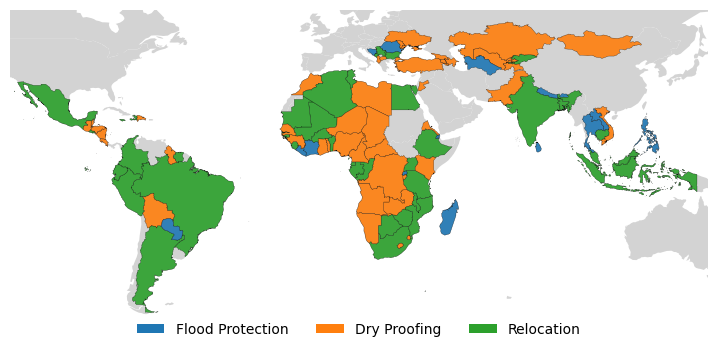

In [396]:
# Plot a map of the adaptation options
# Map parameters
figsize = (9, 6)
adapt_colors = {
    'flood_protection': '#1f77b4',  # blue
    'dry_proofing':     '#ff7f0e',  # orange
    'relocation':       '#2ca02c',  # green
}
xmin = -120
xmax = 145
ymin = -60
ymax = 60

# Create a copy of original dataframe for mapping
map_df = equality_adaptation.copy()
# Simplify the admin boundaries (useful for plotting)
map_df['geometry'] = map_df['geometry'].simplify(tolerance=0.1)

# Color each row by its adaptation
map_df['color'] = map_df['adaptation'].map(adapt_colors)

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Create a basemap of the world
world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
try:
    world = gpd.read_file(world_url)
    world.plot(ax=ax, color='lightgray')
except Exception as e:
    print(f"Couldn't load world map from URL: {e}")
    print("Proceeding without background world map")

# Create a mask for rows with non-null color values
valid_data = ~map_df['color'].isna()

# Plot coutnries with data using metric to control color
map_df[valid_data].plot(ax=ax,
                        color=map_df['color'],
                        edgecolor='black',
                        linewidth=0.2,
                        alpha=0.9,
                        zorder=1)

# # # Add title explicitly to the ax object, not using plt.title
# ax.set_title(title, fontsize=15, pad=20)

# Legend (categorical) — horizontal, across bottom
legend_handles = [
    mpatches.Patch(facecolor=adapt_colors[opt],
                   edgecolor='none',
                   label=opt.replace('_', ' ').title())
    for opt in adapt_colors.keys()
]

# Add a single legend across the bottom
ax.legend(
    handles=legend_handles,
    # title="Adaptation Option",
    loc='upper center',              # place relative to axes
    bbox_to_anchor=(0.5, 0.05),     # centered below the map
    ncol=len(legend_handles),        # all labels in one row
    frameon=False,                   # cleaner, frameless legend
    fontsize=10,
    title_fontsize=10
)

# Set extent
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Turn off the axis
ax.set_axis_off()

plt.show()

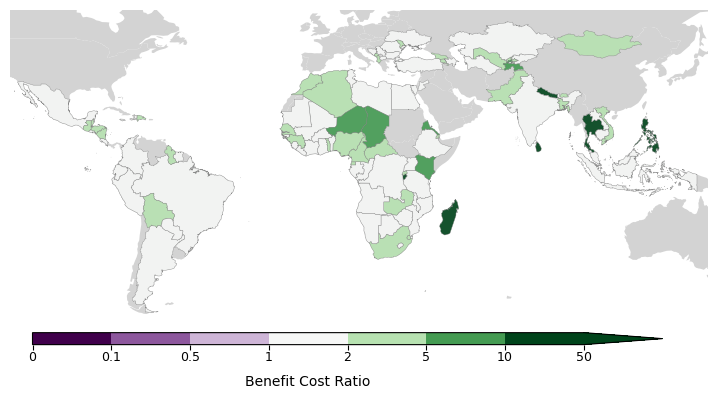

In [397]:
# Plot a map of the flood protection metrics
# Map parameters
figsize = (9, 6)
colormap = plt.cm.PRGn
colormap_min = 0
colormap_max = 2
metric = "bcr"
label = "Benefit Cost Ratio"

# Define discrete bins and colours
bounds = [0, 0.1, 0.5, 1, 2, 5, 10, 50]
n_bins = len(bounds) - 1
base_cmap = plt.cm.PRGn
colors = base_cmap(np.linspace(0, 1, n_bins))
cmap = ListedColormap(colors)
norm_map = BoundaryNorm(bounds, ncolors=n_bins, clip=False)

# Create a copy of original dataframe for mapping
map_df = equality_adaptation.copy()
# Simplify the admin boundaries (useful for plotting)
map_df['geometry'] = map_df['geometry'].simplify(tolerance=0.1)

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Create a basemap of the world
world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
try:
    world = gpd.read_file(world_url)
    world.plot(ax=ax, color='lightgray')
except Exception as e:
    print(f"Couldn't load world map from URL: {e}")
    print("Proceeding without background world map")

# Create a mask for rows with non-null metric values
valid_data = ~map_df[metric].isna()

# # Colormap normalizatoin
# norm = Normalize(vmin=colormap_min, vmax=colormap_max)

# Plot coutnries with data using metric to control color
map_df[valid_data].plot(
    column=metric,
    ax=ax,
    cmap=cmap,
    norm=norm_map,
    edgecolor='gray',
    linewidth=0.3,
    alpha=0.9
)

# # # Add title explicitly to the ax object, not using plt.title
# ax.set_title(title, fontsize=15, pad=20)

# # Create a colourbar
# sm = ScalarMappable(cmap=colormap, norm=norm)
# sm.set_array([])
# # Create the colorbar with custom positioning
# cax = fig.add_axes([0.162, 0.2, 0.7, 0.03])  # [left, bottom, width, height]
# cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
# # Create evenly spaced ticks (5 ticks including min and max)
# tick_values = np.linspace(colormap_min, colormap_max, 5)
# cbar.set_ticks(tick_values)
# # Format the tick labels to have fewer decimal places
# cbar.set_ticklabels([f"{v:.2f}" for v in tick_values])
# cbar.set_label(label)

# Set extent
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)


# Turn off the axis
ax.set_axis_off()

# Create equal-width normalization for the colorbar only
norm_bar = BoundaryNorm(range(n_bins + 1), ncolors=n_bins)

# Position of colorbar [left, bottom, width, height]
cax = fig.add_axes([0.15, 0.2, 0.7, 0.02])

cbar = ColorbarBase(
    cax,
    cmap=cmap,
    norm=norm_bar,
    boundaries=np.arange(n_bins + 1),
    orientation='horizontal',
    spacing='uniform',  # equal-width segments
    extend='max',       # arrow only on right
    extendfrac='auto'
)

# --- Add tick marks at bin edges (numeric labels) ---
cbar.set_ticks(np.arange(n_bins + 1))
cbar.set_ticklabels([f"{b:g}" for b in bounds])
cbar.ax.tick_params(axis='x', bottom=True, top=False, labelsize=9, pad=1)
cbar.set_label(label, labelpad=8, fontsize=10)


plt.show()

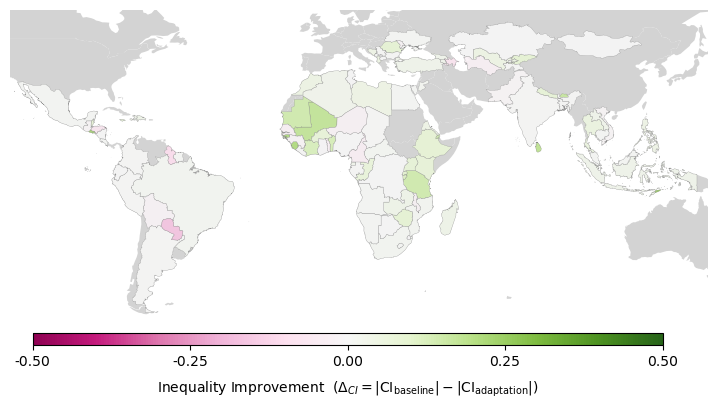

In [398]:
# Plot a map of the flood protection CI metrics
# Map parameters
figsize = (9, 6)
colormap = plt.cm.PiYG
colormap_min = -0.5
colormap_max = 0.5
metric = "CI_delta"
label = "Concentration Index Change"

# Create a copy of original dataframe for mapping
map_df = equality_adaptation.copy()
# Simplify the admin boundaries (useful for plotting)
map_df['geometry'] = map_df['geometry'].simplify(tolerance=0.1)

fig, ax = plt.subplots(1, 1, figsize=figsize)

# Create a basemap of the world
world_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
try:
    world = gpd.read_file(world_url)
    world.plot(ax=ax, color='lightgray')
except Exception as e:
    print(f"Couldn't load world map from URL: {e}")
    print("Proceeding without background world map")

# Plot data for available countries
if metric in map_df.columns:
    # Create a mask for rows with non-null metric values
    valid_data = ~map_df[metric].isna()

    # Colormap normalizatoin
    norm = Normalize(vmin=colormap_min, vmax=colormap_max)

    # Plot coutnries with data using metric to control color
    map_df[valid_data].plot(column=metric,
                            ax=ax,
                            cmap=colormap,
                            norm=norm,
                            edgecolor='gray',
                            linewidth=0.2,
                            alpha=0.9)

# # # Add title explicitly to the ax object, not using plt.title
# ax.set_title(title, fontsize=15, pad=20)

# Set extent
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Create a colourbar
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
# Create the colorbar with custom positioning
cax = fig.add_axes([0.15, 0.2, 0.7, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
# Create evenly spaced ticks (5 ticks including min and max)
tick_values = np.linspace(colormap_min, colormap_max, 5)
cbar.set_ticks(tick_values)
# Format the tick labels to have fewer decimal places
cbar.set_ticklabels([f"{v:.2f}" for v in tick_values])
cbar.set_label(
    r'Inequality Improvement  ($\Delta_{CI} = |\mathrm{CI}_{\mathrm{baseline}}| - |\mathrm{CI}_{\mathrm{adaptation}}|$)',
    labelpad=8,
    fontsize=10
)


# Turn off the axis
ax.set_axis_off()

plt.show()